In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.2


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [3]:
# adata = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
# adata

In [4]:
bdata = sc.read_h5ad('h5ad/df.fil3_gex_bcells.h5ad')
bdata

AnnData object with n_obs × n_vars = 75683 × 385
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

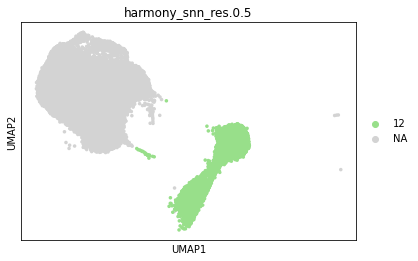

In [5]:
sc.pl.umap(adata[adata.obs['initial_cluster_B'].isin(['B'])], color = ['harmony_snn_res.0.5'], groups = ['12'], size = 50)

In [6]:
df4 = pd.read_csv('../newcastle_covid/datasets/Monaco B cells.txt', sep='\t', header=0, index_col = None, na_filter=False)

In [7]:
def geneset_score(self, genesets, groupby, figsize=(3, 4), cmap = 'viridis', col_cluster = True, row_cluster = True):
    import numpy as np
    import seaborn as sns
    for s in genesets:
        sc.tl.score_genes(self, [y for y in genesets[s] if y != ''], use_raw = True, score_name= str(s)+'_score')
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s)+'_score' for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s)+'_score' for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s)+'_score' for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = col_cluster, row_cluster = row_cluster)
    sc.pl.umap(self, color = [str(s)+'_score' for s in genesets], size = 10, ncols = 2)
    print(g)

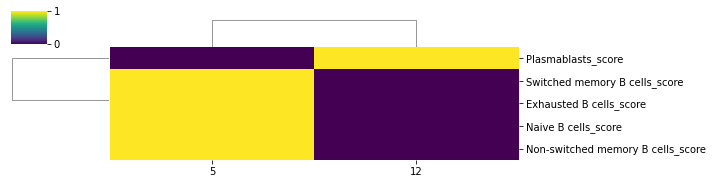

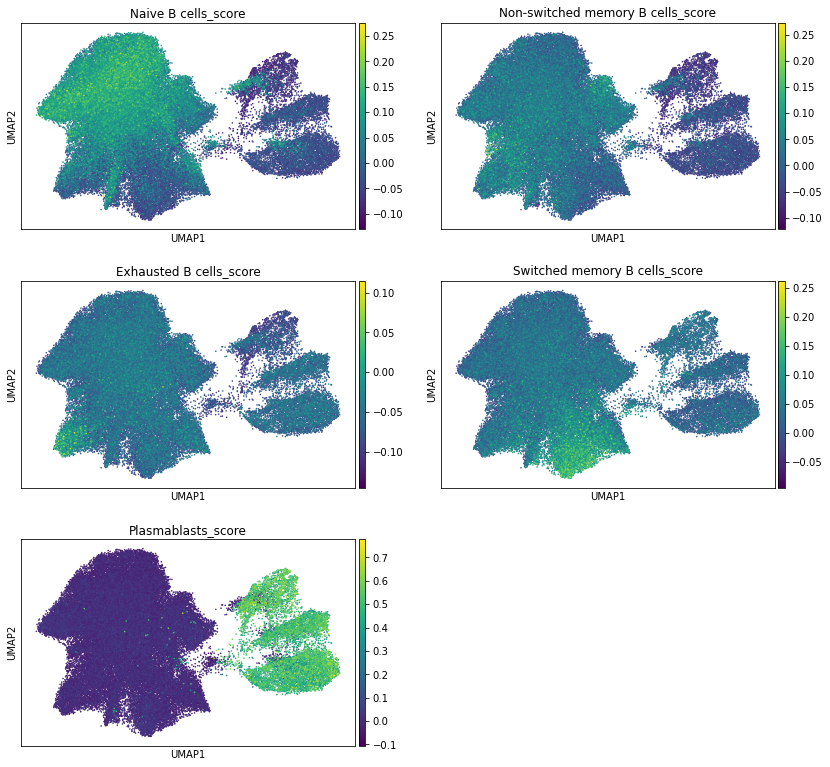

In [8]:
geneset_score(bdata, df4, 'harmony_snn_res.0.5', (10,2.5))

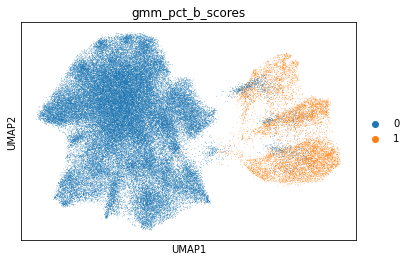

In [9]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2, max_iter=1000, covariance_type='full')
X = bdata.obs[['Naive B cells_score', 'Non-switched memory B cells_score', 'Exhausted B cells_score', 'Switched memory B cells_score', 'Plasmablasts_score']]
bdata.obs['gmm_pct_b_scores'] = gmm.fit(X).predict(X)
bdata.obs['gmm_pct_b_scores'] = bdata.obs['gmm_pct_b_scores'].astype('category')
sc.pl.umap(bdata, color = 'gmm_pct_b_scores')

In [10]:
# read in the BCR files
sampleinfo = pd.read_csv('processed/BCR/bcr_meta.csv')
sampleinfo

,sample,individual
0,C101,C101_tigger
1,C103,C103_tigger
2,C104,C104_tigger
3,C106,C106_tigger
4,C108,C108_tigger
...,...,...
58,C69,C69_tigger
59,C73,C73_tigger
60,C82,C82_tigger
61,C85,C85_tigger


In [12]:
samples = sampleinfo['sample']
bcr_files = []
for sample in samples:
    filelocation = 'processed/BCR/'+ sample +'/dandelion/all_contig_igblast_db-pass_genotyped.tsv'
    bcr_files.append(pd.read_csv(filelocation, sep = '\t'))

In [13]:
# concatenate and check if the table is constructed properly
bcr = bcr_files[0].append(bcr_files[1:])
bcr.reset_index(inplace = True, drop = True)
bcr.shape

(364790, 82)

In [14]:
# to speed this up slightly, I will also remove the barcodes that not found in the transcriptome data
bcr = bcr[bcr['cell_id'].isin(list(set(bdata.obs_names)))]
bcr.shape

(142700, 82)

In [15]:
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.1.11 pandas==1.2.4 numpy==1.20.2 matplotlib==3.3.4 networkx==2.5.1 scipy==1.6.2 skbio==0.5.6


In [16]:
vdj, bdata2 = ddl.pp.filter_contigs(bcr, bdata)

Preparing data: 132088it [02:11, 1005.89it/s]
Annotating in anndata obs slot : 100%|██████████| 75683/75683 [00:12<00:00, 6084.72it/s]


Finishing up filtering
Initializing Dandelion object


In [17]:
vdj

Dandelion class object with n_obs = 50572 and n_contigs = 100872
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_sta

In [18]:
bdata2

AnnData object with n_obs × n_vars = 75683 × 385
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

... storing 'filter_rna' as categorical
... storing 'has_contig' as categorical
... storing 'filter_contig_quality' as categorical
... storing 'filter_contig_VDJ' as categorical
... storing 'filter_contig_VJ' as categorical
... storing 'contig_QC_pass' as categorical


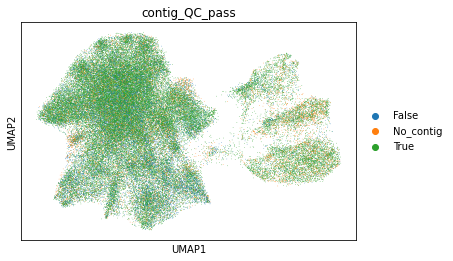

In [19]:
sc.pl.umap(bdata2, color = 'contig_QC_pass')

In [23]:
pd.crosstab(bdata2.obs['filter_contig'], bdata2.obs['contig_QC_pass'])

contig_QC_pass,False,No_contig,True
filter_contig,,,
False,7963,9698,50572
True,7450,0,0


In [20]:
ddl.tl.find_clones(vdj)

Finding clones based on VDJ chains : 100%|██████████| 463/463 [00:05<00:00, 78.92it/s] 
Refining clone assignment based on VJ chain pairing : 100%|██████████| 50572/50572 [00:00<00:00, 383261.83it/s]


In [21]:
if not os.path.exists('h5ddl'):
    os.makedirs('h5ddl')
vdj.write_h5('h5ddl/df.fil3_gex_bcells_vdj.h5ddl', compression = 'blosc:lz4')

In [24]:
ddl.tl.transfer(bdata2, vdj)

In [ ]:
bdata2.write_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad', compression = 'gzip')

... storing 'clone_id' as categorical
... storing 'locus_VDJ' as categorical
... storing 'locus_VJ' as categorical
... storing 'productive_VDJ' as categorical
... storing 'productive_VJ' as categorical
... storing 'v_call_genotyped_VDJ' as categorical
... storing 'v_call_genotyped_VJ' as categorical
... storing 'd_call_VDJ' as categorical
... storing 'j_call_VDJ' as categorical
... storing 'j_call_VJ' as categorical
... storing 'c_call_VDJ' as categorical
... storing 'c_call_VJ' as categorical
... storing 'duplicate_count_VDJ' as categorical
... storing 'duplicate_count_VJ' as categorical
... storing 'junction_aa_VDJ' as categorical
... storing 'junction_aa_VJ' as categorical
... storing 'status' as categorical
... storing 'status_summary' as categorical
... storing 'productive' as categorical
... storing 'productive_summary' as categorical
... storing 'isotype' as categorical
... storing 'isotype_summary' as categorical
... storing 'vdj_status' as categorical
... storing 'vdj_status_s

In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.2


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [3]:
bdata2 = sc.read_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad')
bdata2

AnnData object with n_obs × n_vars = 75683 × 385
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [4]:
# manually exlcude IgD+ cells in the putative ASC cluster
pd.crosstab(bdata2.obs['gmm_pct_b_scores'], bdata2.obs['isotype_summary'])

isotype_summary,IgA,IgD,IgD|IgM,IgE,IgG,IgM,Multi,No_contig,unassigned
gmm_pct_b_scores,,,,,,,,,
0,3386,2856,230,0,4826,32333,45,22351,777
1,3304,42,0,1,2029,737,2,2760,4


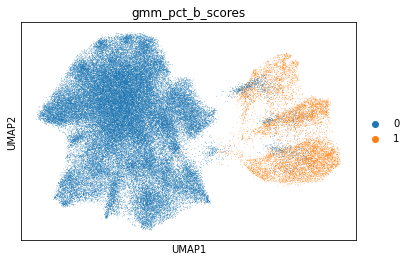

In [5]:
sc.pl.umap(bdata2, color = 'gmm_pct_b_scores')

In [6]:
non_pb = list(bdata2.obs[(bdata2.obs['gmm_pct_b_scores'] == 1) & (bdata2.obs['isotype_summary'] == 'IgD')].index)
len(non_pb)

42

... storing 'celltype_B' as categorical


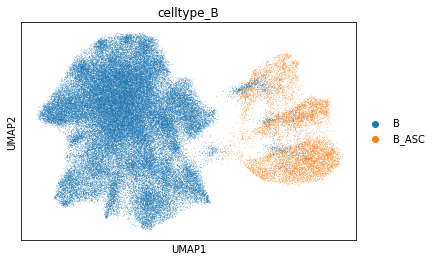

In [7]:
b_dict = {0:'B', 1:'B_ASC'}
bdata2.obs['celltype_B'] = [b_dict[x] for x in bdata2.obs['gmm_pct_b_scores']]
sc.pl.umap(bdata2, color = 'celltype_B')

In [8]:
bdata2.write_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad', compression = 'gzip')

In [9]:
adata = bdata2.raw.to_adata()
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
# subset to bcells and ASC separately
bcell = adata[adata.obs['celltype_B'] == 'B'].copy()
ascs = adata[adata.obs['celltype_B'] == 'B_ASC'].copy()

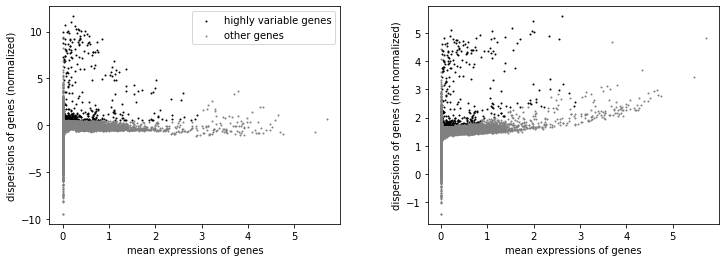

In [11]:
# find highly variable genes
sc.pp.highly_variable_genes(bcell, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bcell)

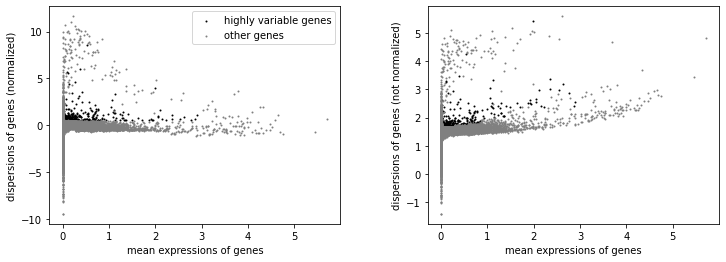

In [12]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bcell.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL', i):
        bcell.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bcell)

In [13]:
# transfer to .raw slot
bcell.raw = bcell

In [14]:
# Filter the rna genes to only those marked as highly-variable
bcell = bcell[:, bcell.var.highly_variable].copy()
bcell

AnnData object with n_obs × n_vars = 66804 × 454
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [15]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(bcell, ['nCount_RNA', 'pct_counts_mt'])
sc.pp.scale(bcell, max_value=10)

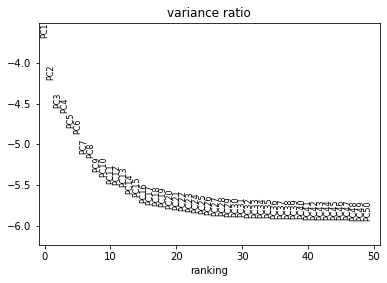

In [16]:
# Run PCA
sc.tl.pca(bcell, svd_solver='arpack')
sc.pl.pca_variance_ratio(bcell, log=True, n_pcs = 50)

In [17]:
# Correcting the PCs with harmonypy
sc.external.pp.harmony_integrate(bcell, 'sample_id', adjusted_basis = 'X_pca')
# Computing the neighborhood graph
sc.pp.neighbors(bcell, n_neighbors=10, n_pcs=30)
# Embedding the neighborhood graph
sc.tl.umap(bcell, min_dist = 0.3)

2021-12-10 17:02:14,875 - harmonypy - INFO - Iteration 1 of 10
2021-12-10 17:03:16,078 - harmonypy - INFO - Iteration 2 of 10
2021-12-10 17:04:17,565 - harmonypy - INFO - Converged after 2 iterations


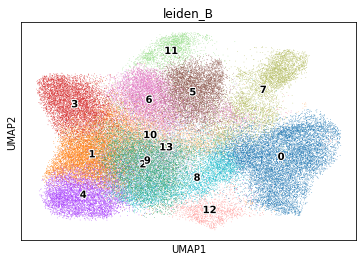

In [18]:
sc.tl.leiden(bcell, key_added = 'leiden_B')
sc.pl.umap(bcell, color = 'leiden_B', legend_loc = 'on data', legend_fontoutline = 2)

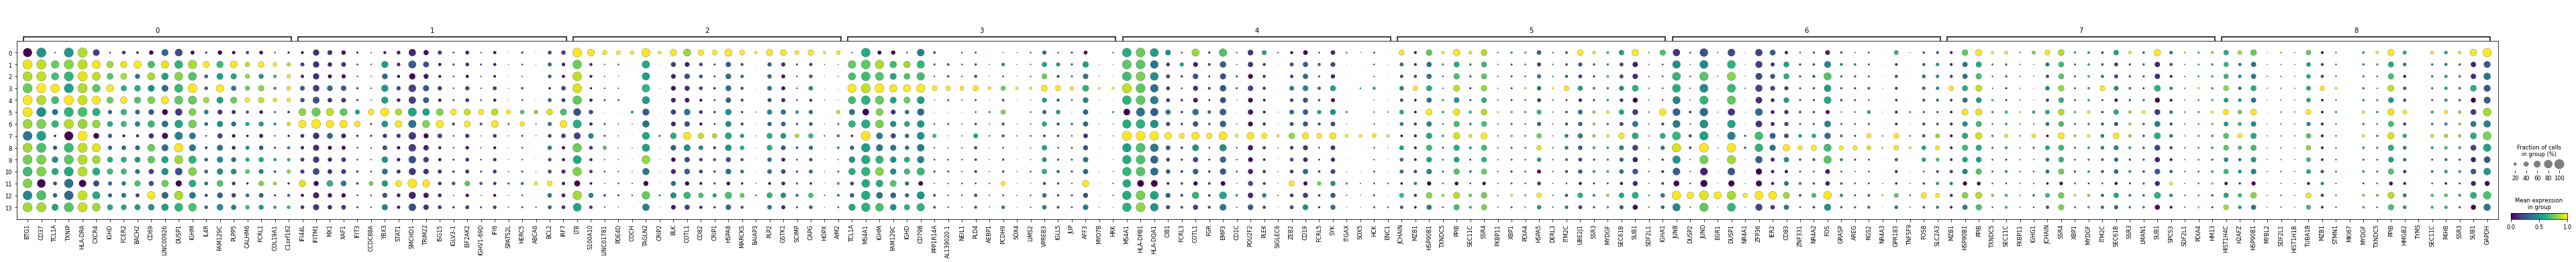

In [19]:
# sc.tl.rank_genes_groups(bcell, groupby = 'leiden_B')
sc.pl.rank_genes_groups_dotplot(bcell, min_logfoldchange =1, n_genes=20, standard_scale = 'var',  color_map = 'viridis', dendrogram = False)

In [20]:
bcell

AnnData object with n_obs × n_vars = 66804 × 454
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

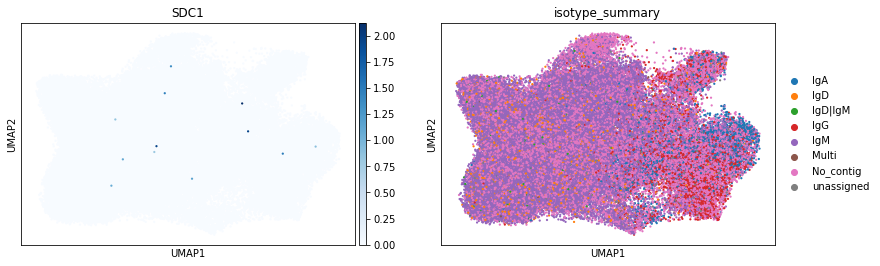

In [23]:
sc.pl.umap(bcell, color=['SDC1', 'isotype_summary'], color_map = 'Blues', size = 20, ncols = 3)

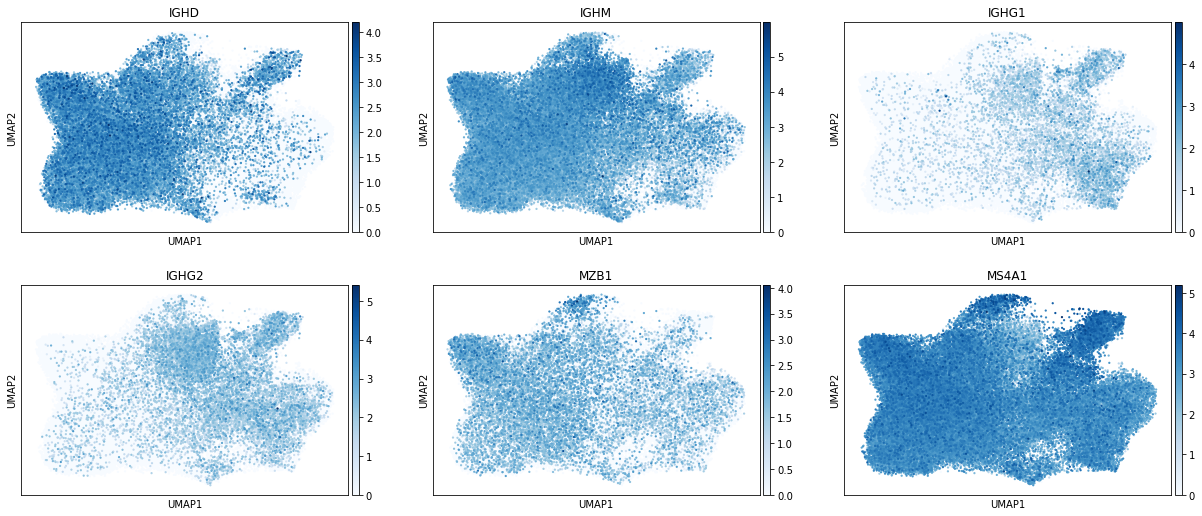

In [24]:
sc.pl.umap(bcell, color=['IGHD', 'IGHM', 'IGHG1', 'IGHG2', 'MZB1', 'MS4A1'], color_map = 'Blues', size = 20, ncols = 3)

In [ ]:
bcell.obs['']